# Classifiez automatiquement des biens de consommation

* l'objectif est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

In [1]:
#imports des librairies
import pandas as pd

import re
import numpy as np
from numpy import array
from numpy import argmax

import os
import datetime
import time
import random
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import sklearn.decomposition as decomposition
from scipy import stats
import scipy.cluster.hierarchy as shc

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score
#bag of words 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
#confusion matrix
from sklearn.metrics import confusion_matrix
#stemming, tokenizer, lemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from skimage import transform

In [2]:
df_products = pd.read_csv('../data/Flipkart/flipkart_com-ecommerce_sample_1050.csv', sep=',')

In [3]:
df_products.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [4]:
df_products_focus = df_products[['uniq_id','product_category_tree','description']]

In [5]:
df_products_focus['product_category_tree'].head(2) 

0    ["Home Furnishing >> Curtains & Accessories >>...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
Name: product_category_tree, dtype: object

In [6]:
def get_category(row):
    category = row
    if row !=np.nan:
        first = row.index('[\"')
        last = row.index(' >>')
        category = category[first+2  : last]
    return category

In [7]:
df_products_focus['category'] = df_products_focus['product_category_tree']
df_products_focus['category'] = df_products_focus['category'].apply (lambda row :  get_category(row))
df_products_focus['category'].unique()

<ipython-input-7-5598f15e1ce2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products_focus['category'] = df_products_focus['product_category_tree']
<ipython-input-7-5598f15e1ce2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products_focus['category'] = df_products_focus['category'].apply (lambda row :  get_category(row))


array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [8]:
categories = df_products_focus['category'].unique()

In [9]:
df_products_focus['description'].describe()

count                                                  1050
unique                                                 1050
top       Flipkart.com: Buy Milton School 750 ml Water B...
freq                                                      1
Name: description, dtype: object

In [10]:
df_products_focus['description'].head()

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
3    Key Features of SANTOSH ROYAL FASHION Cotton P...
4    Key Features of Jaipur Print Cotton Floral Kin...
Name: description, dtype: object

In [11]:
def count_total_words_mean (df, column):
    df['total_words'] = df[column].str.split().str.len()
    df['total_words'].head(5) 
    print('Nombre moyen de mots : '+ str(int(df_products_focus['total_words'].mean())))

In [12]:
count_total_words_mean (df_products_focus, 'description')

Nombre moyen de mots : 76


<ipython-input-11-07a719283bf7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_words'] = df[column].str.split().str.len()


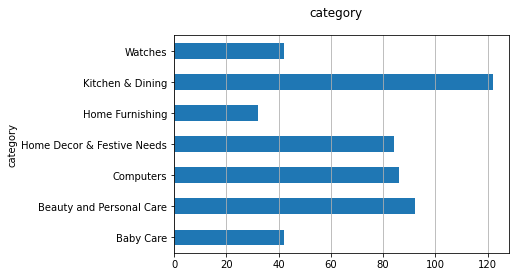

In [13]:
# only for 500 products 
fig, ax = plt.subplots()
fig.suptitle("category", fontsize=12)
df_products_focus["category"].reset_index().head(500).groupby("category").count().plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

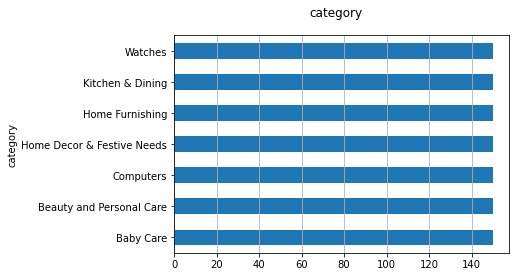

In [14]:
# only for 500 products 
fig, ax = plt.subplots()
fig.suptitle("category", fontsize=12)
df_products_focus["category"].reset_index().groupby("category").count().plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

### Analyse exploratoire

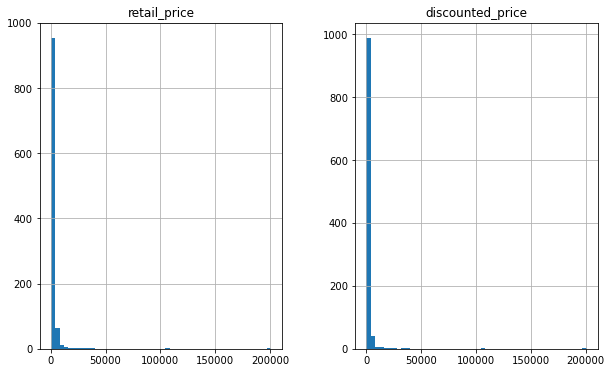

In [18]:
numerical = ['retail_price', 'discounted_price']
df_products[numerical].hist(bins=50, figsize= (10,6))
plt.show()

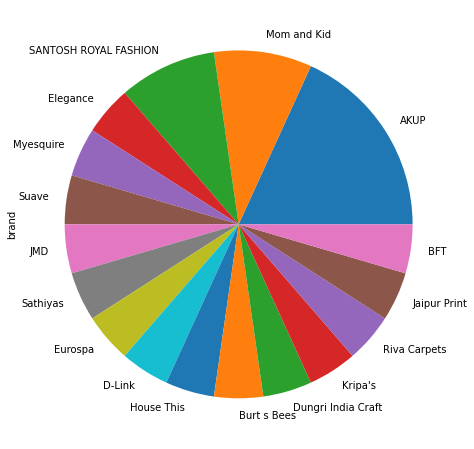

In [19]:
#fonction pour tracer le camembert d'une variable catégoriale
def show_pie(df, column): 
    plt.figure(figsize=(8,8))
    df[column].value_counts(normalize=True).plot(kind='pie')
    plt.show()
show_pie(df_products.head(50), 'brand')

* La répartition des marques sur 50 produits montre l'existance d'un grand nombre de marques dans le dataset

# Fonctions de prétraitement de texte 

In [26]:
#bibliotheque nlp sélectionnée
import nltk
from nltk.corpus import stopwords

### Transformer en miniscule (lowercase )

In [27]:
def lower_case(df, column):
    df[column] = df[column].apply(lambda x: " ".join(x.lower() for x in x.split()))
    df[column].head()
    return df

### Eliminer la ponctuation

In [28]:
def remove_ponctuation(df, column):
    df[column] = df[column].str.replace('[^\w\s]','')
    df[column].head()
    return df

### Eliminer mots vides et unités 

In [29]:
from quantities import units
def remove_stop_words(df, column):
    nltk.download('stopwords')
    stop = stopwords.words('english')
    #get units and add them to stop words list
    unit_symbols = [u.symbol for _, u in units.__dict__.items() if isinstance(u, type(units.deg))]
    for e in unit_symbols :
        stop.append(e)
    df[column] = df[column].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    df[column].head()
    return df

### Tokenization 

In [30]:
def nltk_tokenizer(text):
    tokens_words = nltk.word_tokenize(text)
    tokenized_output = ' '.join(tokens_words)
    return tokenized_output

In [31]:
#autre alternative pour tokenizer avec une librairie différente : spacy
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [32]:
tokens = [list(tokenize(s)) for s in df_products_focus['description']]


### Text cleaning

In [33]:
def clean_text(text):
    # remove html markup
    #text=re.sub("(<.*?>)","",text)
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
    
    #remove whitespace
    text=text.strip()
    return text

### stemming

In [34]:

def stemming_text(text):
    words = text.split(' ')
    # init stemmer
    porter_stemmer=PorterStemmer()
    stemmed_words = [porter_stemmer.stem(word=word) for word in words]
    stemmed_output = ' '.join(stemmed_words)
    return stemmed_output

### Lemmatization

In [35]:

nltk.download('wordnet')
def lemmatize_text(text):
    # init lemmatizer
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Olfa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
from autocorrect import Speller
def spell_correction(text):
    spell = Speller(lang='en')
    spelled_text = [spell(w) for w in text.split()]
    spelled_output = ' '.join(spelled_text)
    return spelled_output

### Part of Speech detection (POS)

In [37]:
import nltk
nltk.download('universal_tagset')
from nltk.tokenize import word_tokenize
def get_tokens_POS(text):
    #tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(word_tokenize(text), tagset='universal')
    final_word_pos_list = []
    final_word_pos= ''
    for pos_tag in pos_tags : 
        new_pos ='_'.join(pos_tag) 
        final_word_pos_list.append(new_pos)
    final_word_pos = ' '.join(final_word_pos_list)
    return final_word_pos

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Olfa\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [39]:
#vecteur des mots et leurs fréquences
word_dist = get_word_dist(df_products_focus, 'description')


<ipython-input-24-3a7ca35f1fe3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: clean_text(x))
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olfa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-29-6def21a82b18>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
<ipython-input-24-3a7ca35f1fe3>:6: SettingWithC

In [44]:
word_dist_df = pd.DataFrame(word_dist.items(), columns=['word', 'frequency'])
word_dist_df = word_dist_df.sort_values(by=['frequency'], ascending=False).head(50)

In [50]:
word_dist_df.head()

,word,frequency
13,rs,911
137,products,631
235,free,618
224,buy,581
238,delivery,567


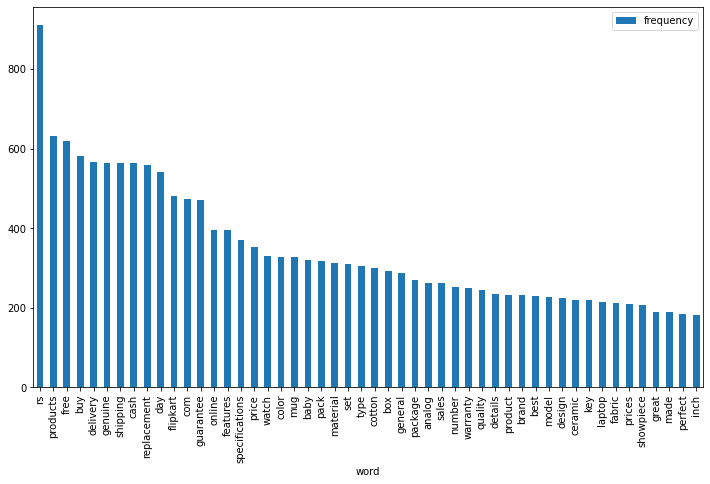

In [54]:
#bar plot de nombre d'occurrences des mots dans le corpus 
word_dist_df.set_index('word').plot.bar(figsize=(12,7))
plt.show()

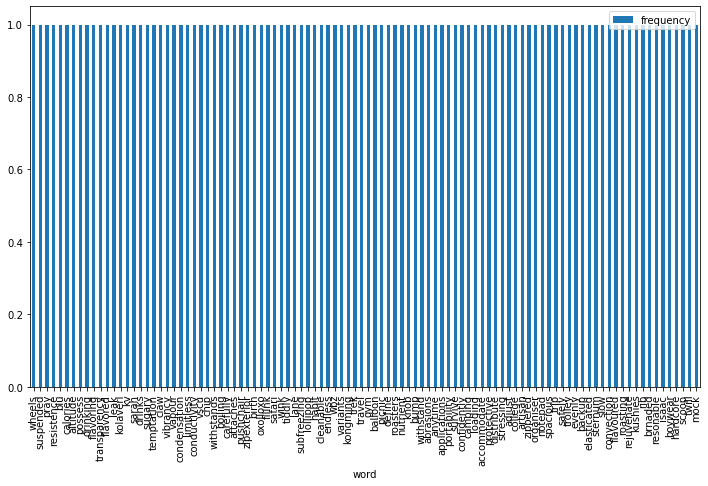

In [57]:
word_dist_df_ = pd.DataFrame(word_dist.items(), columns=['word', 'frequency'])
word_dist_df_ = word_dist_df_.sort_values(by=['frequency'], ascending=True).head(100)
word_dist_df_.set_index('word').plot.bar(figsize=(12,7))
plt.show()

# Méthodes de vectorisation

## Bag of words

In [58]:
def clean_description(df, column):
    df[column] = df[column].apply(lambda x: clean_text(x))
    df= lower_case(df, column)
    df= remove_ponctuation(df, column)
    df= remove_stop_words(df, column)
    df['cleaned_description'] = df[column]
    df['cleaned_description'] = df['cleaned_description'].apply(lambda x: spell_correction(x))
    df['cleaned_description'] = df['cleaned_description'].apply(lambda x: stemming_text(x))
    df['cleaned_description'] = df['cleaned_description'].apply(lambda x: nltk_tokenizer(x))
    return df

In [59]:
def get_word_dist(df, column):
    df = clean_description(df, column)
    
    a = df[column].str.lower().str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(a)
    word_dist = nltk.FreqDist(words)
    word_dist
    return word_dist

In [60]:
word_dist = get_word_dist(df_products_focus, 'description')

<ipython-input-58-84a4a9d3795f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: clean_text(x))
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olfa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-29-6def21a82b18>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
<ipython-input-58-84a4a9d3795f>:6: SettingWithC

In [61]:
def get_most_frequent_words(word_dist):
    word_freq_df = pd.DataFrame(word_dist.items(), columns=['word', 'frequency'])
    word_freq_df = word_freq_df[word_freq_df['frequency'] > 2]
    most_frequent_words = word_freq_df['word'].values
    return most_frequent_words

In [62]:
most_frequent_words =  get_most_frequent_words(word_dist)

In [63]:
def generate_bow_vectors (df, column, max_features):
    bow = CountVectorizer(max_features=max_features, lowercase=True, ngram_range=(1,1), analyzer = "word")
    train_bow = bow.fit_transform(df_products_focus['cleaned_description'])
    words = bow.get_feature_names()
    return train_bow, words

In [64]:
max_features = len (most_frequent_words)
train_bow, words_bow = generate_bow_vectors(df_products_focus, 'cleaned_description', max_features)

## n-grams avec n =2 

In [66]:
from nltk import ngrams
def get_ngram(x, n):
    ngram = ngrams(x.split(' '), n=n)
    ngrams_list =[]
    for gram in ngram:
        ngrams_list.append(" ".join(x for x in gram)) 
        ngrams_list.append(",")
    ngram= " ".join(x for x in ngrams_list)
    return ngram

In [80]:
df_products_focus['ngram'] = df_products_focus.description.apply(lambda x: get_ngram(x, 2)) 
print(df_products_focus['ngram'].head(5))
list_words =[]
for i in df_products_focus['ngram'].values:
    for e in i.split(',') : 
        list_words.append(e)
#list_words = np.concatenate(df_products_focus['ngram'].values)
print(len(list_words))
word_dist = nltk.FreqDist(list_words)
word_freq_df = pd.DataFrame(word_dist.items(), columns=['word', 'frequency'])
print(word_freq_df.shape)
word_freq_df = word_freq_df[word_freq_df['frequency'] > 1]
#word_freq_df = word_freq_df.sort_values(by=['frequency'], ascending=False).head(1000)
print(word_freq_df.shape)
most_frequent_words = word_freq_df['word'].values
df_columns =[]
for word in most_frequent_words :
    df_columns.append(word)
df_columns.append('category')
df_product_ngram = pd.DataFrame()
df_product_ngram['uniq_id']= df_products_focus['uniq_id']
for element in most_frequent_words :
    df_product_ngram[element] = df_products_focus.description.str.count(element)
df_product_ngram['target_category'] = df_products_focus ['category']
#ngrams_3 = get_ngram(df_products_focus, 'cleaned_description',  3)

<ipython-input-80-644870020b19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products_focus['ngram'] = df_products_focus.description.apply(lambda x: get_ngram(x, 2))


0    key features , features elegance , elegance po...
1    specifications sathiyas , sathiyas cotton , co...
2    key features , features eurospa , eurospa cott...
3    key features , features santosh , santosh roya...
4    key features , features jaipur , jaipur print ...
Name: ngram, dtype: object
55682
(18667, 2)
(8457, 2)


In [81]:
df_product_ngram.head()

,uniq_id,key features,elegance polyester,polyester multicolor,multicolor abstract,abstract eyelet,eyelet door,door curtain,curtain height,height pack,...,buy uberlyfe,uberlyfe extra,large pigmented,pigmented polyvinyl,polyvinyl films,films imported,imported sticker,online uberlyfe,uberlyfe large,target_category
0,55b85ea15a1536d46b7190ad6fff8ce7,1,3,3,3,3,3,4,2,2,...,0,0,0,0,0,0,0,0,0,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Home Furnishing


In [131]:
dict_ = {'Home Furnishing':1, 'Baby Care':2, 'Watches':3,
       'Home Decor & Festive Needs':4, 'Kitchen & Dining':5,
       'Beauty and Personal Care':6, 'Computers':0} 
df_products_focus['category']= df_products_focus['category'].map(dict_)

## Term frequency - inverse document frequency -tf-idf

In [83]:
def generate_tfidf_vectors(df, column,  max_features):
    
     
     #TF-IDF vectorizer
    tfv = TfidfVectorizer(max_features = max_features, ngram_range = (1,1))
    vec_text = tfv.fit_transform(df[column].values)
    words = tfv.get_feature_names()
    return vec_text, words

In [84]:
df_products_focus.head()
tfidf_vectors, words_tfidf = generate_tfidf_vectors(df_products_focus, 'cleaned_description',  max_features )
tfidf_vectors

<1050x2410 sparse matrix of type '<class 'numpy.float64'>'
	with 32815 stored elements in Compressed Sparse Row format>

## Word2vec pré-entrainé sur wikipedia


In [85]:
def treat_text(df, column):
    df[column] = df[column].apply(lambda x: clean_text(x))
    df= lower_case(df, column)
    df= remove_ponctuation(df, column)
    df= remove_stop_words(df, column)
    df[column] = df[column].apply(lambda x: lemmatize_text(x))
    
    df['pos_description'] = df[column].apply(lambda x:  get_tokens_POS(x))
    return df

# possibilité de combiner l'utilisation de lemming et stemming si ça ne permet pas d'avoir le vecteur (not in vocab)

In [86]:
df_products_focus = treat_text(df_products_focus, 'description')
df_products_focus.head(5)

<ipython-input-85-ba002c56b797>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: clean_text(x))
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olfa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-29-6def21a82b18>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
<ipython-input-85-ba002c56b797>:6: SettingWithC

,uniq_id,product_category_tree,description,category,total_words,cleaned_description,ngram,pos_description
0,55b85ea15a1536d46b7190ad6fff8ce7,"[""Home Furnishing >> Curtains & Accessories >>...",key feature elegance polyester multicolor abst...,1,230,key featur eleg polyest multicolor abstract te...,"key features , features elegance , elegance po...",key_ADJ feature_NOUN elegance_NOUN polyester_N...
1,7b72c92c2f6c40268628ec5f14c6d590,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",specification sathiyas cotton bath towel bath ...,2,74,specif sathiya cotton bath towel bath towel re...,"specifications sathiyas , sathiyas cotton , co...",specification_NOUN sathiyas_VERB cotton_NOUN b...
2,64d5d4a258243731dc7bbb1eef49ad74,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",key feature eurospa cotton terry face towel se...,2,215,key featur europa cotton terri face towel set ...,"key features , features eurospa , eurospa cott...",key_ADJ feature_NOUN eurospa_VERB cotton_NOUN ...
3,d4684dcdc759dd9cdf41504698d737d8,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature santosh royal fashion cotton print...,1,145,key featur santo royal fashion cotton print ki...,"key features , features santosh , santosh roya...",key_ADJ feature_NOUN santosh_VERB royal_ADJ fa...
4,6325b6870c54cd47be6ebfbffa620ec7,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature jaipur print cotton floral king si...,1,214,key featur jaipur print cotton floral king siz...,"key features , features jaipur , jaipur print ...",key_ADJ feature_NOUN jaipur_NOUN print_NOUN co...


In [87]:
import gensim
from gensim.models import Word2Vec
model_file = "./word2vec/model.txt"
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(model_file)
word2vec_model.init_sims(replace=True)


In [98]:
def strIntersection(s1, s2):
    out = ""
    for c in s1:
        if c in s2 and not c in out:
            out += c
    return out[:-1]


In [95]:

def vector(word, model):
    max_intersection_word = ""
    max_intersection_len = 0
    for w in model.vocab :
        l = len(strIntersection(w, word))
        if l> max_intersection_len :
            max_intersection_len = l
            max_intersection_word = w
    return max_intersection_word


In [103]:
def get_mean_vector(row, column, model):
    mean_vector = []
    doc = row.split(' ')
    #mean_vector = np.array([np.array([model.wv.get_vector(word)]) if word in model.vocab else vector(word, model) for word in doc ])
    mean_vector = np.array([np.array([model.wv.get_vector(word)]) for word in doc if word in model.vocab])
    return np.array(mean_vector)


In [105]:

def get_word_embeding_vectors (model, df, column):
    df = treat_text(df, column)
    #sum(float(embedding) for embedding in listOfEmb) / len(listOfEmb)
    word2vec_data = df.pos_description.apply(lambda x: np.mean(get_mean_vector(x, 'pos_description', model), axis = 0))
    #word2vec_data = df.pos_description.apply(lambda x: sum(float(embedding) for embedding in get_mean_vector(x, 'pos_description', model))/len(get_mean_vector(x, 'pos_description', model)))
    return   np.array(word2vec_data)  
word2vec_data = get_word_embeding_vectors (word2vec_model, df_products_focus, 'description')    


<ipython-input-85-ba002c56b797>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: clean_text(x))
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olfa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-29-6def21a82b18>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
<ipython-input-85-ba002c56b797>:6: SettingWithC

### Bert en Transfer learning

In [106]:
from sentence_transformers import SentenceTransformer

### Download the model 
bert = SentenceTransformer('all-distilroberta-v1')
#bert = SentenceTransformer('paraphrase-MiniLM-L6-v2')


C:\Users\Olfa\anaconda3\lib\site-packages\transformers\configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [107]:
from tqdm.notebook import tqdm
tqdm.pandas()
bert_vectors = np.vstack(df_products_focus['cleaned_description'].progress_apply(bert.encode))

C:\Users\Olfa\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


C:\Users\Olfa\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


## Autre façon moins abstraite de faire du word embeding avec BERT en transfer learning 

In [108]:
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch

bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True,)
# Setting up the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [109]:
def bert_text_preparation(text, tokenizer):

    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors

In [110]:
def get_bert_embeddings(text, tokenizer, model):
    #text input preparation
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
    # convert the input into embedings 
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state : The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

In [139]:
#df_products_focus.category = df_products_focus.category.map({'Home Furnishing' : 0, 'Baby Care' :1, 'Watches' : 2, 'Home Decor & Festive Needs' : 3, 
                                                             #'Kitchen & Dining' : 4, 'Beauty and Personal Care' : 5, 'Computers' : 6})
df_products_focus['category'] = df_products['product_category_tree']
df_products_focus['category'] = df_products_focus['category'].apply (lambda row :  get_category(row))
dict_ = {'Home Furnishing':0, 'Baby Care':1, 'Watches':2,
       'Home Decor & Festive Needs':3, 'Kitchen & Dining':4,
       'Beauty and Personal Care':5, 'Computers':6} 
df_products_focus['category']= df_products_focus['category'].map(dict_)
df_products_focus.head(30)


,uniq_id,product_category_tree,description,category,total_words,cleaned_description,ngram,pos_description
0,55b85ea15a1536d46b7190ad6fff8ce7,"[""Home Furnishing >> Curtains & Accessories >>...",key feature elegance polyester multicolor abst...,0,230,key featur eleg polyest multicolor abstract te...,"key features , features elegance , elegance po...",key_ADJ feature_NOUN elegance_NOUN polyester_N...
1,7b72c92c2f6c40268628ec5f14c6d590,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",specification sathiyas cotton bath towel bath ...,1,74,specif sathiya cotton bath towel bath towel re...,"specifications sathiyas , sathiyas cotton , co...",specification_NOUN sathiyas_VERB cotton_NOUN b...
2,64d5d4a258243731dc7bbb1eef49ad74,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",key feature eurospa cotton terry face towel se...,1,215,key featur europa cotton terri face towel set ...,"key features , features eurospa , eurospa cott...",key_ADJ feature_NOUN eurospa_VERB cotton_NOUN ...
3,d4684dcdc759dd9cdf41504698d737d8,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature santosh royal fashion cotton print...,0,145,key featur santo royal fashion cotton print ki...,"key features , features santosh , santosh roya...",key_ADJ feature_NOUN santosh_VERB royal_ADJ fa...
4,6325b6870c54cd47be6ebfbffa620ec7,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature jaipur print cotton floral king si...,0,214,key featur jaipur print cotton floral king siz...,"key features , features jaipur , jaipur print ...",key_ADJ feature_NOUN jaipur_NOUN print_NOUN co...
5,893aa5ed55f7cff2eccea7758d7a86bd,"[""Watches >> Wrist Watches >> Maserati Time Wr...",maserati time r analog watch boy buy maserati ...,2,42,maserati time r analog watch boy buy maserati ...,"maserati time , time r , r analog , analog wat...",maserati_NOUN time_NOUN r_ADJ analog_NOUN watc...
6,f355cc1ccb08bd0d283ed979b7ee7515,"[""Watches >> Wrist Watches >> Camerii Wrist Wa...",camerii wm elegance analog watch men boy buy c...,2,44,camera wm eleg analog watch men boy buy camera...,"camerii wm , wm elegance , elegance analog , a...",camerii_NOUN wm_NOUN elegance_NOUN analog_NOUN...
7,dd0e3470a7e6ed76fd69c2da27721041,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",star uft tsw bk br analog watch boy price r wh...,2,131,star ft ts bk br analog watch boy price rs whe...,"star uft , uft tsw , tsw bk , bk br , br analo...",star_NOUN uft_ADJ tsw_NOUN bk_NOUN br_NOUN ana...
8,41384da51732c0b4df3de8f395714fbb,"[""Watches >> Wrist Watches >> Alfajr Wrist Wat...",alfajr wy youth digital watch men boy buy alfa...,2,66,affair wy youth digit watch men boy buy affair...,"alfajr wy , wy youth , youth digital , digital...",alfajr_NOUN wy_NOUN youth_NOUN digital_ADJ wat...
9,710ed5f2393a4b9e8823aa0029f71f93,"[""Watches >> Wrist Watches >> TAG Heuer Wrist ...",tag heuer cau ba formula analog watch boy men ...,2,63,tag neuer can ba formula analog watch boy men ...,"tag heuer , heuer cau , cau ba , ba formula , ...",tag_NOUN heuer_NOUN cau_NOUN ba_NOUN formula_N...


In [111]:
def get_mean_vector_bert(row, column, model, tokenizer):
    mean_vector = []
    mean_vector = get_bert_embeddings(row, tokenizer, model)
    return np.array(mean_vector)

In [112]:
def get_bert_word_embeding_vectors (model, df, column, tokenizer):
    
    #bert_embedding_data = df.column.apply(lambda x: np.mean(get_mean_vector(x, column, model), axis = 0)).to_numpy()
    bert_embedding_data = df.description.apply(lambda x: np.mean(get_mean_vector_bert(x, column, model, tokenizer), axis = 0)).to_numpy()
    return  np.array(bert_embedding_data)  
bert_embedding_data = get_bert_word_embeding_vectors (bert_model, df_products_focus, 'description', tokenizer)    


## clustering et evaluation

In [113]:
n_clusters= 7
#strategy peut etre égale à bow, tfidf, word2vec
def k_means(train, X, n_clusters, strategy):
    kmeans = KMeans(n_clusters=n_clusters, init= 'k-means++', n_init=10)
    clustering_ori = kmeans.fit_predict(train)
    column_cluster = "clusters_"+strategy
    X[column_cluster] =  kmeans.labels_
    return clustering_ori, X


In [114]:
def tsne_kmeans(n_clusters, X, clustering_ori, n_components): 

    Xtsne = TSNE(n_components=n_components).fit_transform(X)
    dftsne = pd.DataFrame(Xtsne)

    dftsne['cluster'] = clustering_ori
    dftsne.columns = ['x1','x2','cluster']

    plt.figure(figsize=(10,10))
    plt.title('Représentation des clusters (k-means) avec  T-SNE')
    sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster', legend='full',
                   palette=sns.color_palette("hls",n_clusters))
    plt.legend(loc='upper left', labels=dftsne['cluster'].unique())
    plt.show()

In [141]:
X = df_products_focus.copy()
clustering_bow, X = k_means(train_bow, X, n_clusters, "bow")
#adjusted_rand
print(metrics.adjusted_rand_score(df_products_focus['category'].values, clustering_bow))
#confusion_matrix
m_bow = confusion_matrix(clustering_bow, df_products_focus['category'].values)        


0.06779210727684241


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6')])

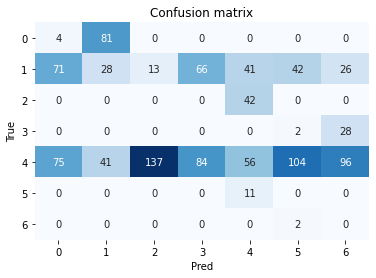

In [142]:
m_bow
classes = np.unique(df_products_focus['category'].values)
fig, ax = plt.subplots()
sns.heatmap(m_bow, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

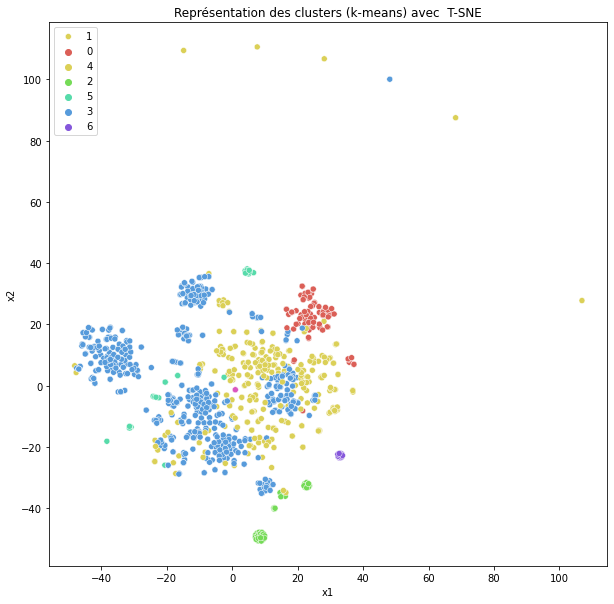

In [143]:
tsne_kmeans(n_clusters, train_bow, clustering_bow, 2)

0    0
1    1
Name: category, dtype: int64
0.028070001738059118


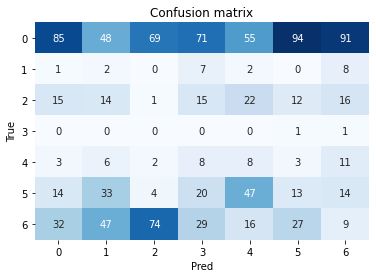

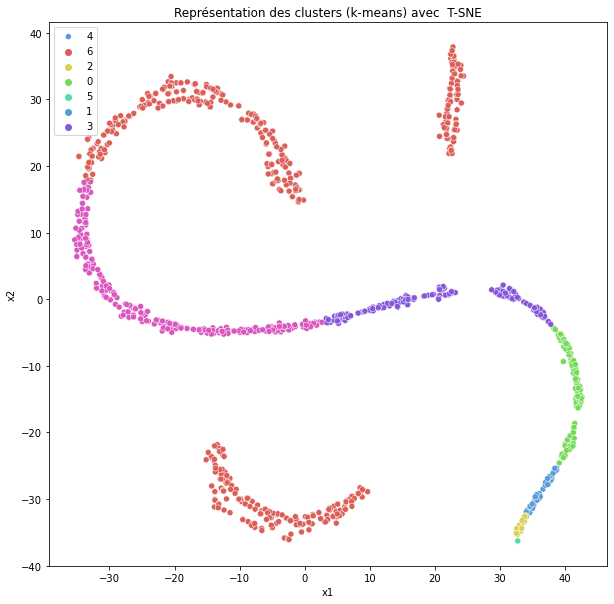

In [144]:
df_numerics_only = df_product_ngram.select_dtypes(include=np.number)
print(df_products_focus['category'].head(2))
clustering_2_gram, X = k_means(df_numerics_only.values, X, n_clusters, "2_gram")
#adjusted_rand
print(metrics.adjusted_rand_score(df_products_focus['category'], X['clusters_2_gram'].values))
#confusion_matrix
m_2_gram = confusion_matrix(X['clusters_2_gram'].values, df_products_focus['category'].values)        
m_2_gram
fig, ax = plt.subplots()
sns.heatmap(m_2_gram, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
tsne_kmeans(n_clusters, df_numerics_only.values, clustering_2_gram, 2)

In [145]:
clustering_tfidf, X = k_means(tfidf_vectors, X, n_clusters, "tfidf")
#adjusted_rand
print(metrics.adjusted_rand_score(df_products_focus['category'], X['clusters_tfidf'].values))
#confusion_matrix
m_tfidf = confusion_matrix(X['clusters_tfidf'].values, df_products_focus['category'].values)        


0.28485990183509047


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6')])

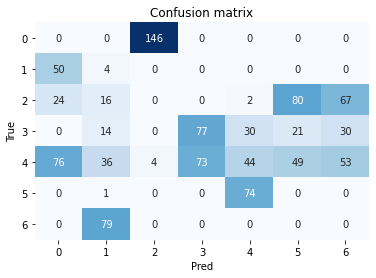

In [146]:
m_tfidf
fig, ax = plt.subplots()
sns.heatmap(m_tfidf, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

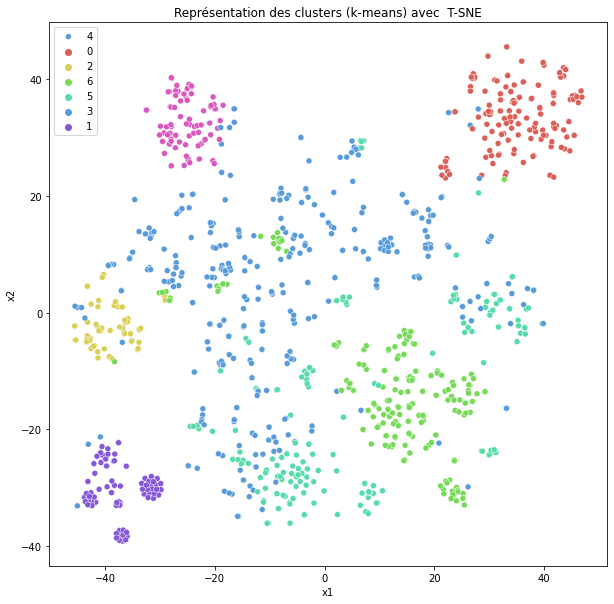

In [147]:
tsne_kmeans(n_clusters, tfidf_vectors, clustering_tfidf, 2)

In [148]:
clustering_word2vec, X = k_means(np.concatenate(word2vec_data, axis = 0), X, n_clusters, "word2vec")
#adjusted_rand
print(metrics.adjusted_rand_score(df_products_focus['category'], X['clusters_word2vec'].values))
#confusion_matrix
m_word2vec = confusion_matrix(X['clusters_word2vec'].values, df_products_focus['category'].values)        


0.35981807367730434


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6')])

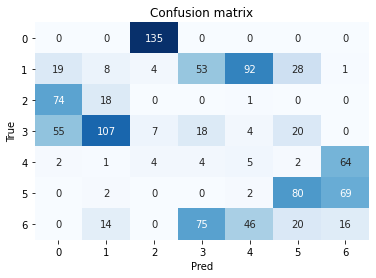

In [149]:
m_word2vec
fig, ax = plt.subplots()
sns.heatmap(m_word2vec, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

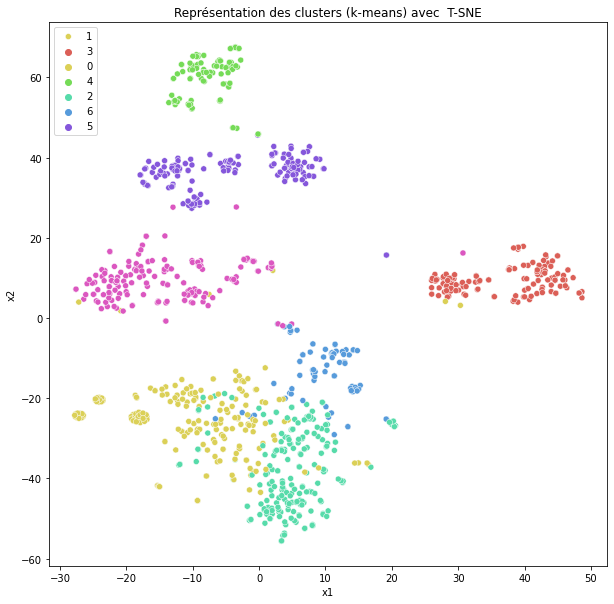

In [150]:
tsne_kmeans(n_clusters, np.concatenate(word2vec_data, axis = 0), clustering_word2vec, 2) 

* Meilleur valeur de rand ajusté obtenue pour le modèle word2vec avec transfer learning (0.36 par rapport à 0.2 pour tfidf et moins de 0.1 pour bag of words)

In [151]:
clustering_Bert, X = k_means(bert_vectors, X, n_clusters, "Bert")
#adjusted_rand
print(metrics.adjusted_rand_score(df_products_focus['category'], X['clusters_Bert'].values))
#confusion_matrix
m_Bert = confusion_matrix(X['clusters_Bert'].values, df_products_focus['category'].values)        


0.2787040326366605


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6')])

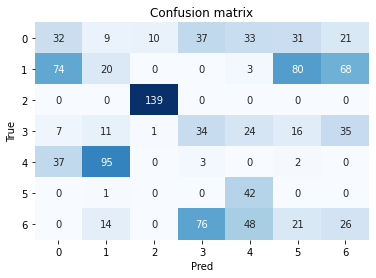

In [152]:
m_Bert
fig, ax = plt.subplots()
sns.heatmap(m_Bert, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

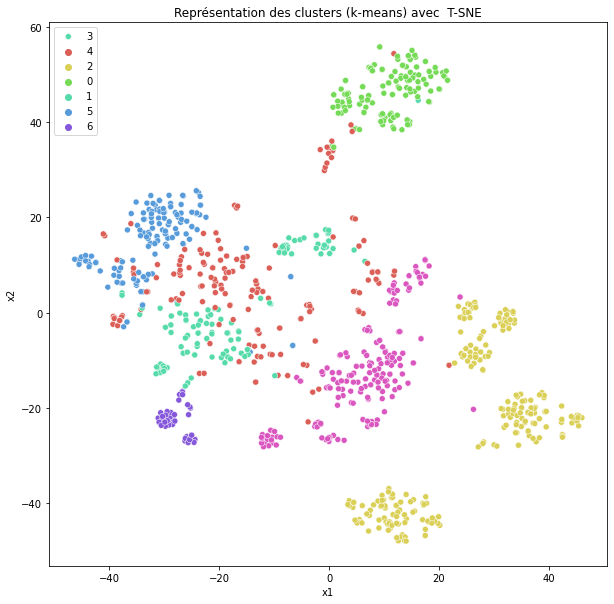

In [153]:
tsne_kmeans(n_clusters, bert_vectors, clustering_Bert, 2) 

In [161]:
#print(bert_embedding_data)
bert_embedding_data_vector =[]
for e in range (0, len(bert_embedding_data)):
    bert_embedding_data_vector.append(bert_embedding_data[e])
clustering_Bert_t, X = k_means(bert_embedding_data_vector, X, n_clusters, "Bert_t")
#adjusted_rand
print(metrics.adjusted_rand_score(df_products_focus['category'], X['clusters_Bert_t'].values))
#confusion_matrix
m_Bert_t = confusion_matrix(X['clusters_Bert_t'].values, df_products_focus['category'].values)        


0.30095156265493805


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6')])

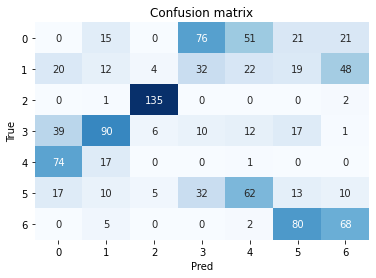

In [162]:
m_Bert_t
fig, ax = plt.subplots()
sns.heatmap(m_Bert_t, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

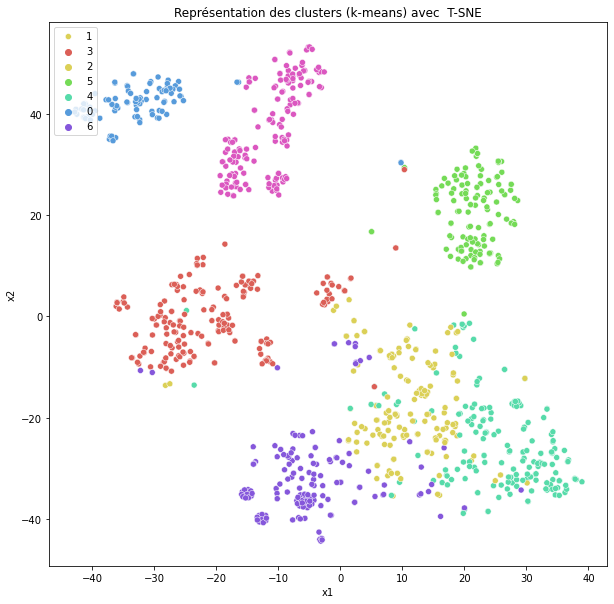

In [163]:
tsne_kmeans(n_clusters, bert_embedding_data_vector, clustering_Bert_t, 2) 

## Modèle supervisé

In [164]:
def compute_time (start_time): 
    train_time = time.time() - start_time
    return train_time

In [165]:
# Application d'un modèle supervisé
def split_data(vectors, df):
    X = vectors
    #y = df.iloc[:,-1:].values
    y = df["category"].values
    X_train,  y_train, X_test, y_test = train_test_split(X, y)
    return X_train, y_train, X_test, y_test 

In [166]:
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.model_selection import KFold
kFold = KFold(n_splits=5, random_state=None, shuffle=False)
#la liste des hyperparamètre à partir du nom du modèle 
def define_model_hyperparameters (model_name):
    if model_name == 'Gradient Boosting' or  model_name == 'Gradient Boosting_RS' : 
        learning_rate= [0.01,0.02,0.03,0.04]
        n_estimators= [100, 150, 200]
        max_depth= [3, 5, 7, 10]
        min_samples_leaf= [5, 10, 20]
        hyperparameters = dict(learning_rate= learning_rate, n_estimators= n_estimators, max_depth= max_depth, min_samples_leaf= min_samples_leaf)
            
    return hyperparameters

#initialisation du modèle apartir du nom
def initialize_model (model_name):
    if model_name == 'Gradient Boosting' or  model_name == 'Gradient Boosting_RS': 
        model = GradientBoostingRegressor()
    elif model_name == 'Random Forests' or  model_name == 'Random Forests_RS': 
        model = RandomForestRegressor()

    return model

def perform_randomsearch_cross_validation(kfold, model_name, results): 
    print(model_name)
    hyperparameters = define_model_hyperparameters (model_name)
    model= initialize_model (model_name)
    start_time = time.time()
    randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,cv=kfold, param_distributions=hyperparameters, scoring="r2")
    searchResults = randomSearch.fit(X_train, y_train)
    train_time = compute_time (start_time)
    bestModel = searchResults.best_estimator_
    bestModel.fit(X_train, y_train)
    print ("Best model hyper parameters : {0}".format(bestModel))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, bestModel.predict(X_test)))
    r2= metrics.r2_score(y_test, bestModel.predict(X_test))
    #get_feature_importances(model_name, model, X_train.columns)
    results = add_to_results(results, model_name+"_RS", rmse, r2, train_time)
    print("RMSE : {0}, R2 : {1}, Time :{2}".format(rmse, r2, train_time))
    return results, bestModel

def run_gradient_boosting_prediction(X_train, y_train, X_test, y_test):
    start_time = time.time()
    gbr = GradientBoostingClassifier()
    gbr.fit(X_train, y_train)
    train_time = compute_time (start_time)
    y_pred = gbr.predict(X_test)
    gbr.score(X_test, y_test)
    compute_accuracy(y_test, y_pred)

def compute_accuracy(y_test, predictions):
    accuracy = metrics.accuracy_score(y_test, predictions)
    #compute accuracy on each class 
    print("Accuracy globale : "+ str(accuracy))
    # Get the confusion matrix
    matrix = confusion_matrix(y_test, predictions)
    print(matrix.diagonal()/matrix.sum(axis=1))

In [167]:
#word2vec 
X_train_w, y_train_w, X_test_w,  y_test_w = split_data(np.concatenate(word2vec_data, axis = 0), X)
#results_cross_validation, bestModelgb =  perform_randomsearch_cross_validation(kFold, 'Gradient Boosting', results_cross_validation)
run_gradient_boosting_prediction(X_train_w, X_test_w, y_train_w, y_test_w)

Accuracy globale : 0.870722433460076
[0.82758621 0.90322581 0.97619048 0.85714286 0.90909091 0.61904762
 0.98039216]


* Accuracy  par classe : 
* classe 'Home Furnishing' = 0.94117647 ,
* classe 'Baby Care' = 0.84848485,
* classe 'Watches' = 0.97222222 ,
* classe 'Home Decor & Festive Needs' = 0.81481481,
* classe 'Kitchen & Dining' = 0.96875 , 
* classe 'Beauty and Personal Care' = 0.81081081,
* classe 'Computers' = 0.91891892
* Accuracy globale = 0.8897338403041825

In [169]:
#bert 
X_train_b, y_train_b, X_test_b,  y_test_b = split_data(bert_embedding_data_vector, X)
#results_cross_validation, bestModelgb =  perform_randomsearch_cross_validation(kFold, 'Gradient Boosting', results_cross_validation)
run_gradient_boosting_prediction(X_train_b, X_test_b, y_train_b, y_test_b)

Accuracy globale : 0.8517110266159695
[0.80487805 0.74285714 0.97560976 0.74193548 0.83333333 0.83333333
 1.        ]


* Accuracy  par classe : 
* classe 'Home Furnishing' = 0.80,
* classe 'Baby Care' = 0.74
* classe 'Watches' =  0.97 ,
* classe 'Home Decor & Festive Needs' = 0.0.74
* classe 'Kitchen & Dining' =  0.83
* classe 'Beauty and Personal Care' = 0.83
* classe 'Computers' =  1
* Accuracy globale = 0.85

# traitement des images 

In [170]:
#import skimage library 
from skimage.filters import gaussian, threshold_mean, median, laplace, unsharp_mask
from skimage import io
from skimage.feature import match_descriptors, corner_harris, corner_peaks, ORB, plot_matches
from skimage.color import rgb2gray

In [312]:
image_repository = "../data/Flipkart/Images/"
#images_list_files = os.listdir(image_repository)
images_list_files = df_products['uniq_id'].values
for i in range(0, len(images_list_files)) :
    images_list_files[i] = images_list_files[i]+'.jpg'
print(images_list_files)
image_repository_resized = "../data/Flipkart/resized/"


['55b85ea15a1536d46b7190ad6fff8ce7.jpg'
 '7b72c92c2f6c40268628ec5f14c6d590.jpg'
 '64d5d4a258243731dc7bbb1eef49ad74.jpg' ...
 '5912e037d12774bb73a2048f35a00009.jpg'
 'c3edc504d1b4f0ba6224fa53a43a7ad6.jpg'
 'f2f027ad6a6df617c9f125173da71e44.jpg']


In [172]:
def plot_transformed_image(image):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(image, cmap=plt.cm.gray)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, image.shape[1], image.shape[0], 0])

    plt.show()

In [173]:
from PIL import Image
def fix_size(image_file, image_name, image_repository_resized,  desired_w=256, desired_h=256, fill_color=(255, 255, 255, 255)):
    image = Image.open(image_file)
    x, y = image.size

    ratio = x / y
    desired_ratio = desired_w / desired_h

    w = max(desired_w, x)
    h = int(w / desired_ratio)
    if h < y:
        h = y
        w = int(h * desired_ratio)

    new_im = Image.new('RGBA', (w, h), fill_color)
    new_im.paste(image, ((w - x) // 2, (h - y) // 2))
    new_im = new_im.convert('RGB')
    new_im.save(image_repository_resized + image_name+'.jpg', 'JPEG')
    return new_im.resize((desired_w, desired_h))

In [174]:
for image_file in  images_list_files : 
        #the image name 
        image_name = image_file[: image_file.index('.')]
        image_file = image_repository +image_file
        image = io.imread(image_file)
        fix_size(image_file, image_name, image_repository_resized,  desired_w=256, desired_h=256, fill_color=(255, 255, 255,255))
   

C:\Users\Olfa\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


500


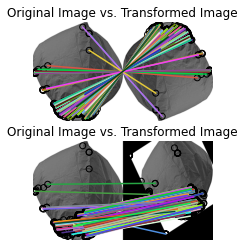

500


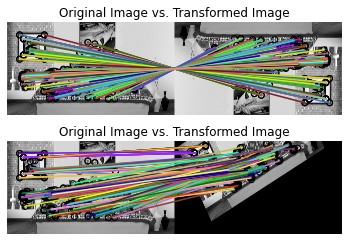

In [176]:

def test_orb(file_path):
    img1 = io.imread(file_path)
    img1 = rgb2gray(img1)
    img2 = transform.rotate(img1, 180)
    tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                                      translation=(0, -200))
    img3 = transform.warp(img1, tform)

    descriptor_extractor = ORB()

    descriptor_extractor.detect_and_extract(img1)
    keypoints1 = descriptor_extractor.keypoints
    descriptors1 = descriptor_extractor.descriptors
    print(len(keypoints1))
    descriptor_extractor.detect_and_extract(img2)
    keypoints2 = descriptor_extractor.keypoints
    descriptors2 = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(img3)
    keypoints3 = descriptor_extractor.keypoints
    descriptors3 = descriptor_extractor.descriptors

    matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
    matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

    fig, ax = plt.subplots(nrows=2, ncols=1)

    plt.gray()

    plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
    ax[0].axis('off')
    ax[0].set_title("Original Image vs. Transformed Image")

    plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
    ax[1].axis('off')
    ax[1].set_title("Original Image vs. Transformed Image")


    plt.show()

test_orb('C:/Users/Olfa/Desktop/P6_Olfa_Allani/data/Flipkart/Images/0a3b5fdf77a361c2d7d9b29c259b8c4e.jpg')
test_orb('C:/Users/Olfa/Desktop/P6_Olfa_Allani/data/Flipkart/Images/0a8a1e9c6659361c0c2b247f8a6471d0.jpg')

In [318]:
from skimage.morphology import disk
def filtering_images(image, filter_name):
    if filter_name == "median":
        t_img = median(image)
    elif filter_name == "gaussian":
        t_img = gaussian(image, sigma=0.4)
    elif filter_name == "laplacian":
        t_img = laplace(image, ksize=3, mask=None)
    elif filter_name == "unsharp":
        t_img = unsharp_mask(image, radius=0.5, amount=2)
        
    #plot_transformed_image(image)
    return t_img

median


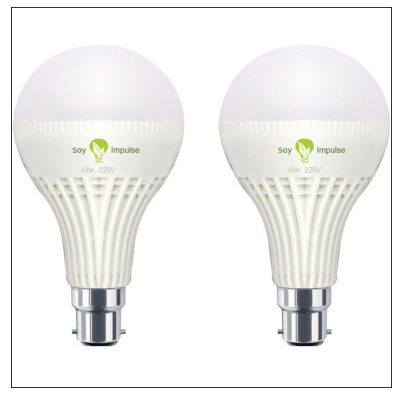

gaussian


<ipython-input-180-e7dbe1c4a98a>:6: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  t_img = gaussian(image, sigma=0.4)


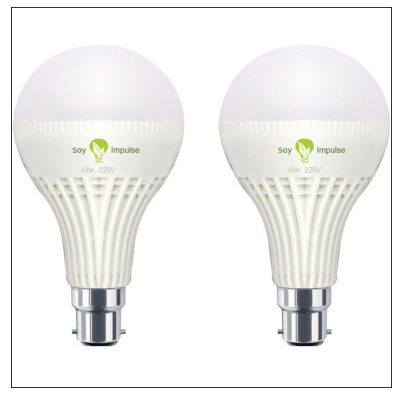

laplacian


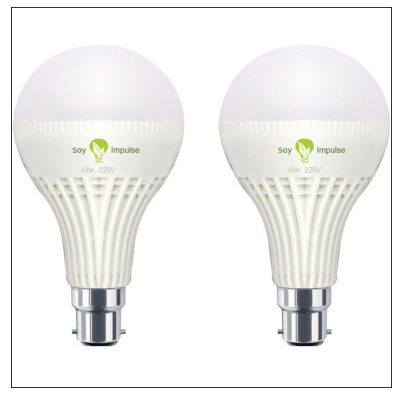

unsharp


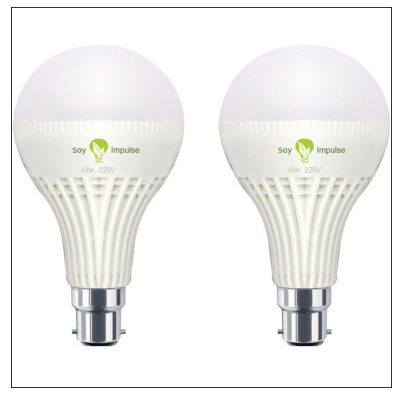

In [183]:
from skimage import filters
#test different filters on images 
image_file1 = image_repository +images_list_files[10]
image_name = images_list_files[10][: images_list_files[10].index('.')]
fix_size(image_file1, image_name, image_repository_resized, desired_w=224, desired_h=224, fill_color = (255,255,255))
image_file_resized_1 = image_repository_resized +images_list_files[10]
image1 = io.imread(image_file_resized_1)
list_of_filters= ["median", "gaussian", "laplacian", "unsharp"]
for filter_name in list_of_filters :
    print(filter_name)
    filtering_images(image1, filter_name)
    

In [184]:
def extract_orb(image, index):
    image_gs = rgb2gray(image)
   
    try :
        descriptor_extractor = ORB(n_keypoints=200)
        empty =[]
        descriptor_extractor.detect_and_extract(image_gs)
        keypoints = descriptor_extractor.keypoints
        nkey = len(keypoints)
        descriptors = descriptor_extractor.descriptors
    except:
        print(index)
        print("An exception occurred")
        descriptors = empty
        nkey = 0
    return nkey, descriptors


In [313]:
def get_list_descriptors(images_list_files, image_repository):
    list_descriptors =[]
    list_nkeys =[]
    i = 0
    for image_file in  images_list_files : 
        image_name = image_file[: image_file.index('.')]
        image_file = image_repository +image_file
        image = io.imread(image_file)
        image = filtering_images(image, "gaussian")
        i +=1
        if image is not None :
            if extract_orb(image, i) is not None :
                list_descriptors.append(extract_orb(image, i)[1])
                list_nkeys.append(extract_orb(image, i)[0])
    return list_nkeys, list_descriptors

In [314]:
import scipy.sparse as sparse
def create_visual_word_(df, images_list_files, k): 
    list_nkeys, list_descriptors = get_list_descriptors(images_list_files, image_repository)
    return list_nkeys, list_descriptors



In [315]:
def get_image_subset(df,  nb_per_subset):
    df_subset = pd.DataFrame()
    for cat in range(0,7) :
        print(cat)
        df_subset = df_subset.append(df[df["category"]== cat].sample(n = nb_per_subset), ignore_index=True)
    return df_subset

In [316]:
df_subset = pd.DataFrame()
df_subset = get_image_subset(df_products_focus, 10)
df_subset.shape

0
1
2
3
4
5
6


(70, 8)

In [190]:
images_list_names = df_subset['uniq_id'].values
image_repository = "../data/Flipkart/Images/"
images_list_files_subset = []
for image_name in  images_list_names : 
    image_file = image_name+'.jpg'
    images_list_files_subset.append(image_file)

df_visual_words_subset = pd.DataFrame()
df_visual_words_subset = create_visual_word_(df_subset, images_list_files_subset, 0)   

In [191]:
from yellowbrick.cluster import KElbowVisualizer
# Silhouette Score for K means
def silhouette_score_visualisation (X, model, mini, maxi):
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(mini, maxi), metric='silhouette', timings= False)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

In [204]:
def kmeans_clustering(X, mini, maxi):
    K = range(mini, maxi)
    
    for k in K:
        print(k)
        km = KMeans(n_clusters=k, init= 'k-means++', n_init=10)
        km = km.fit(X)
    #silhouette 
    silhouette_score_visualisation (X, km, mini, maxi)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


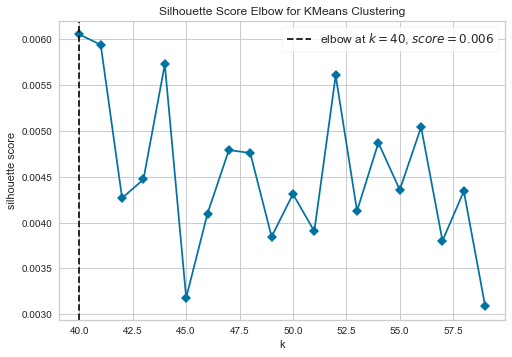

In [205]:
mini = 40
maxi = 60
kmeans_clustering(np.concatenate(df_visual_words_subset[1], axis =0), mini, maxi)

* Meilleure valeur de score silhouette à k = 43 puis autre proche valeur à k = 50 : On séléctionne k = 50

In [215]:
def k_means_img(train, X, n_clusters, strategy):
    kmeans = KMeans(n_clusters=n_clusters, init= 'k-means++', n_init=10)
    clustering_ori = kmeans.fit_predict(train)
    column_cluster = "clusters_"+strategy
    #X[column_cluster] =  kmeans.labels_
    return clustering_ori, X 


In [319]:
list_nkeys, list_descriptors = create_visual_word_(df_products_focus, images_list_files, 50)

<ipython-input-318-3515b49cb953>:6: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  t_img = gaussian(image, sigma=0.4)


344
An exception occurred
344
An exception occurred
344
An exception occurred


In [320]:
def reduce_dimension(list_nkeys, list_descriptors, k):
    if k != 0 :
        new_list_descriptor = []
        for e in range (0, len(list_descriptors)) :
            descriptor = list_descriptors[e]
            #print(list_nkeys[e])
            x= min(k, list_nkeys[e])
            if x>0 :
                new_descriptor = []
                kmeans = KMeans(n_clusters=x).fit(descriptor)
                kmeans.predict(descriptor)
                labels = kmeans.labels_
                if len(labels)>0 : 
                    #print(labels)
                    #n = len(np.unique(labels))
                    #x= min(k, n)
                    #print(n)
                    for i in range(0, x) :
                        #print(i)
                        #new_descriptor[i] =
                        #print(labels.tolist().count(i))
                        new_descriptor.append(labels.tolist().count(i))
            new_list_descriptor.append(new_descriptor)
    return np.array(new_list_descriptor)

In [321]:
print(len(list_descriptors))
X_opt = pd.DataFrame()   
X_opt = reduce_dimension(list_nkeys, list_descriptors, 50)

1050


<ipython-input-320-3327eba5cf80>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(new_list_descriptor)


In [408]:
data_bovw =  pd.DataFrame.from_records(X_opt)
data_bovw = data_bovw.fillna(0)
data_bovw.head() 
#data_bovw.isnull().any()


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1,6,5,4,5.0,14.0,8.0,3.0,4.0,4.0,...,4.0,5.0,4.0,7.0,1.0,3.0,2.0,3.0,2.0,3.0
1,5,8,4,6,13.0,2.0,6.0,7.0,1.0,6.0,...,1.0,6.0,3.0,7.0,2.0,4.0,3.0,3.0,1.0,6.0
2,3,7,12,2,5.0,3.0,8.0,6.0,4.0,5.0,...,2.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,3.0
3,3,6,4,4,5.0,9.0,5.0,5.0,4.0,8.0,...,2.0,3.0,3.0,5.0,3.0,1.0,5.0,6.0,2.0,2.0
4,3,4,4,2,5.0,6.0,3.0,7.0,3.0,3.0,...,6.0,2.0,3.0,3.0,5.0,3.0,3.0,2.0,4.0,2.0


In [323]:
print(data_bovw)
clustering_bovw, X = k_means_img(data_bovw.values, X, 7 , "BOVW")
print(clustering_bovw)
#print(len(labels_bovw))

      0   1   2   3     4     5     6    7    8    9   ...   40   41   42  \
0      1   6   5   4   5.0  14.0   8.0  3.0  4.0  4.0  ...  4.0  5.0  4.0   
1      5   8   4   6  13.0   2.0   6.0  7.0  1.0  6.0  ...  1.0  6.0  3.0   
2      3   7  12   2   5.0   3.0   8.0  6.0  4.0  5.0  ...  2.0  3.0  3.0   
3      3   6   4   4   5.0   9.0   5.0  5.0  4.0  8.0  ...  2.0  3.0  3.0   
4      3   4   4   2   5.0   6.0   3.0  7.0  3.0  3.0  ...  6.0  2.0  3.0   
...   ..  ..  ..  ..   ...   ...   ...  ...  ...  ...  ...  ...  ...  ...   
1045   3   2   7   7   2.0  13.0   4.0  2.0  3.0  2.0  ...  4.0  5.0  2.0   
1046   6   8   1   4   5.0   5.0  11.0  4.0  6.0  4.0  ...  3.0  4.0  1.0   
1047   5   7   1   3   2.0   4.0   4.0  4.0  9.0  8.0  ...  5.0  3.0  1.0   
1048   7   4   5   7   6.0   2.0   5.0  8.0  6.0  5.0  ...  2.0  1.0  1.0   
1049   7   4   4   5   4.0   7.0   8.0  5.0  6.0  7.0  ...  2.0  1.0  1.0   

       43   44   45   46   47   48   49  
0     7.0  1.0  3.0  2.0  3.0  2.

In [324]:
print(len(clustering_bovw))
print(metrics.adjusted_rand_score(df_products_focus['category'], clustering_bovw))
#confusion_matrix
m_bovw = confusion_matrix(clustering_bovw, df_products_focus['category'].values)  
m_bovw

1050
0.002323408549217548


array([[35, 48, 32, 48, 35, 48, 23],
       [15, 18, 29, 16, 16, 21, 15],
       [22, 18, 15, 16, 20, 19, 21],
       [31, 22, 25, 25, 31, 28, 26],
       [19, 16, 23, 21, 25, 14, 26],
       [27, 27, 26, 24, 23, 20, 32],
       [ 1,  1,  0,  0,  0,  0,  7]], dtype=int64)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6')])

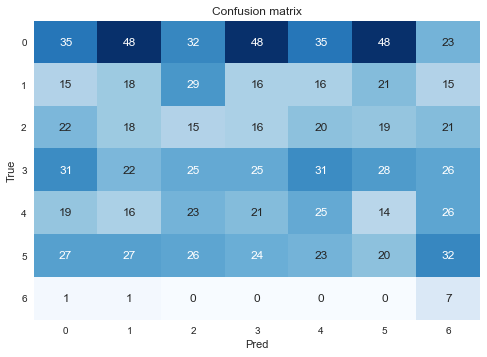

In [325]:
classes = np.unique(clustering_bovw)
fig, ax = plt.subplots()
sns.heatmap(m_bovw, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

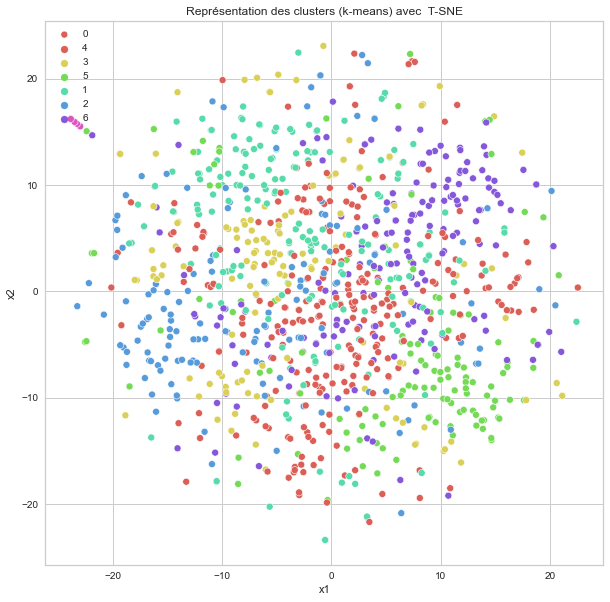

In [342]:
tsne_kmeans(n_clusters, data_bovw.values, clustering_bovw, 2) 

### Apprentissage des features avec un modèle de deep learning VGG-16 (en transfer learning)


In [326]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16


In [327]:
def import_model():
    # import the VGG16 model
    base_model = VGG16(weights="imagenet", include_top=False)
    #base_model.trainable = False
    
    # summarize the model
    base_model.summary()
    return base_model


In [328]:
base_model = import_model()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [329]:
def extract_features_vgg16(image, model):
    # load an image from file, convert the image pixels to a numpy array, reshape data for the model
    image = load_img(image, target_size=(224, 224))
    #image = transform.resize(image, output_shape=(224, 224))
    array_image = img_to_array(image)
    array_image = np.expand_dims(array_image,  axis=0)
    
    array_image = preprocess_input(array_image)
    
    vgg16_feature = model.predict(array_image)
    vgg16_feature_np = np.array(vgg16_feature)
    
    return vgg16_feature_np


In [330]:
from PIL import Image

def get_list_features_vgg16(images_list_files, image_repository_resized, model):
    vgg16_feature_list =[]
    for i in  range (0, len(images_list_files)) : #images_list_files : 
        image_file = images_list_files[i]
        image_name = image_file[: image_file.index('.')]
        image_file = image_repository_resized +image_file
        #with open(image_file, 'rb') as f:
            #image = Image.open(f)
        #image = io.imread(image_file)
        if image_file is not None:
            vgg16_feature_list.append(extract_features_vgg16(image_file, model))#.flaten()
            #list_descriptors.append(extract_features_vgg16(image_file, model))
    return vgg16_feature_list

In [331]:
image_repository = "../data/Flipkart/Images/"
vgg16_feature_list = get_list_features_vgg16 (images_list_files , image_repository, base_model)

C:\Users\Olfa\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [332]:
def k_means_img_vgg(vgg16_feature_list, n_clusters, strategy):
    vgg16_feature_list_np = np.array(vgg16_feature_list)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vgg16_feature_list_np)
    clustering_ori = kmeans.predict(vgg16_feature_list_np)
    labels = kmeans.labels_
    return clustering_ori, labels

In [333]:
#print((vgg16_feature_list[0]))
vgg16_data_concatenated = []
for element in vgg16_feature_list :
    vgg16_data_concatenated.append(np.concatenate(np.concatenate(np.concatenate(element, axis=0), axis=0), axis=0)) 
data_vgg16 =  pd.DataFrame.from_records(vgg16_data_concatenated)
data_vgg16 = data_vgg16.fillna(0)
data_vgg16.head() 
#data_vgg16.isnull().any()


,0,1,2,3,4,5,6,7,8,9,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,0.0,0.0,0.0,0.0,11.387655,0.0,0.0,0.0,0.0,0.0,...,0.000000,56.457672,0.0,0.0,30.503441,23.302755,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,2.554688,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,3.481686,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,9.846517,0.000000,0.0,0.0,39.281593,0.000000,6.781469,0.0,0.000000,0.0


In [334]:
clustering_vgg16, labels_vgg16 = k_means_img_vgg(data_vgg16.values, 7, "VGG16")

In [336]:
#adjusted_rand
print(metrics.adjusted_rand_score(labels_vgg16, df_products_focus['category']))


0.2792209429986846


In [339]:
#adjusted_rand
print(metrics.adjusted_rand_score(labels_vgg16, df_products_focus['category']))
#confusion_matrix
m_vgg16 = confusion_matrix(labels_vgg16, df_products_focus['category'].values)  
#m_vgg16 = m_vgg16.astype('float') / m_vgg16.sum(axis=1)[:, np.newaxis]

0.2792209429986846


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6')])

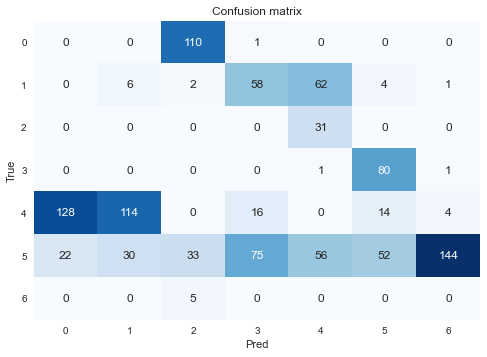

In [340]:
m_vgg16
fig, ax = plt.subplots()
sns.heatmap(m_vgg16, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

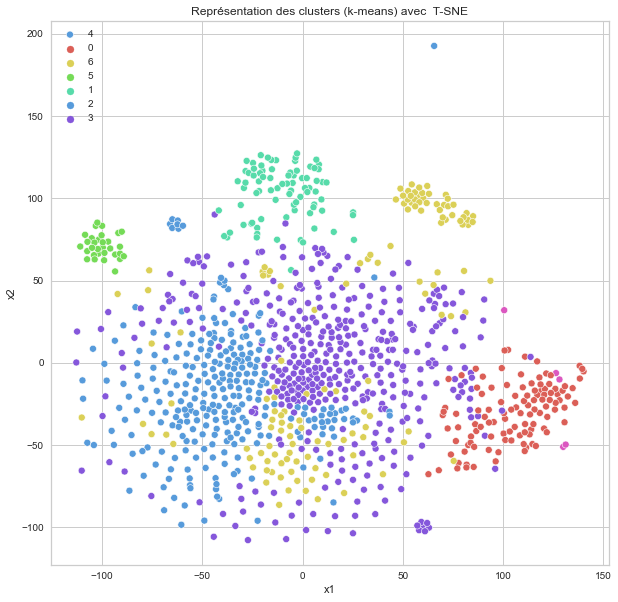

In [341]:
tsne_kmeans(n_clusters, data_vgg16.values, clustering_vgg16, 2) 

### ou encore

In [266]:
from keras.models import Model
from keras import models

base_model_complete = VGG16(weights="imagenet", include_top=True)   
model_VGG16 = models.Model(inputs=base_model_complete.input, outputs=base_model_complete.get_layer('flatten').output)
vgg16_feature_list_flaten = get_list_features_vgg16 (images_list_files , image_repository, base_model_complete)

553476096/553467096 [==============================] - 2463s 4us/step


C:\Users\Olfa\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [267]:
model_VGG16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [365]:
#print((vgg16_feature_list[0]))
vgg16_data_concatenated_ = []
for element in vgg16_feature_list_flaten :
    vgg16_data_concatenated_.append(np.concatenate(element)) 
data_vgg16_ =  pd.DataFrame.from_records(vgg16_data_concatenated_)
data_vgg16_ = data_vgg16_.fillna(0)
data_vgg16_.head() 
#data_vgg16.isnull().any()


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,4.224054e-08,5.390095e-08,3.374634e-08,2.614299e-08,5.288852e-08,1.103025e-06,2.865682e-08,8.051540e-08,3.190812e-07,2.409926e-08,...,2.471466e-06,2.433642e-07,6.517840e-07,4.395975e-08,1.063108e-07,9.057315e-06,1.185970e-06,2.033665e-07,8.452226e-07,1.036587e-04
1,4.215308e-07,3.041928e-07,3.342255e-07,7.194405e-07,1.010929e-06,8.030357e-05,1.284045e-07,1.460601e-07,3.287459e-07,1.940838e-06,...,2.657906e-06,1.236160e-06,1.060407e-07,3.218111e-07,1.857518e-06,3.418592e-05,8.161987e-06,1.197457e-06,1.828408e-06,1.182662e-04
2,1.398766e-07,1.041817e-06,1.617355e-08,2.428785e-08,1.586566e-08,9.167447e-07,1.691886e-08,2.118827e-07,4.340211e-07,1.170787e-07,...,6.445109e-08,5.618292e-08,6.633447e-08,1.675872e-08,1.312230e-08,7.761299e-08,1.106105e-07,1.318426e-08,6.929555e-07,3.472247e-04
3,7.195108e-10,7.640844e-09,1.997716e-10,2.754748e-10,5.866531e-10,5.783461e-10,9.837992e-11,1.555972e-09,2.708173e-10,1.510239e-08,...,9.334865e-10,8.324805e-09,1.651408e-10,8.631231e-10,3.227226e-09,2.640872e-09,3.903454e-09,7.450154e-11,6.835186e-07,8.954413e-08
4,1.977701e-07,7.562117e-07,6.748287e-08,3.237062e-07,6.331716e-07,1.238568e-06,7.914284e-07,2.395126e-07,1.725036e-07,2.745322e-08,...,1.832069e-06,3.293144e-07,8.476073e-08,4.261381e-07,2.027279e-07,1.128361e-07,5.271818e-07,9.803953e-08,1.157290e-05,1.951964e-04


In [366]:
clustering_vgg16_, labels_vgg16_ = k_means_img_vgg(np.concatenate(vgg16_feature_list_flaten, axis=0), 7, "VGG16")
#adjusted_rand
print(metrics.adjusted_rand_score(df_products_focus['category'], labels_vgg16_))
#confusion_matrix
m_vgg16_ = confusion_matrix(labels_vgg16_, df_products_focus['category'].values)        

0.0003579274642039135


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6')])

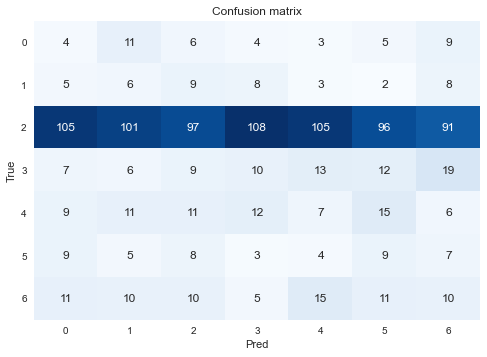

In [367]:
m_vgg16_
fig, ax = plt.subplots()
sns.heatmap(m_vgg16_, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

In [407]:
X_train_v, y_train_v, X_test_v,  y_test_v = split_data(data_vgg16, df_products_focus)
#results_cross_validation, bestModelgb =  perform_randomsearch_cross_validation(kFold, 'Gradient Boosting', results_cross_validation)
run_gradient_boosting_prediction(X_train_v, X_test_v, y_train_v, y_test_v)

Accuracy globale : 0.7566539923954373
[0.68085106 0.65625    0.875      0.7        0.775      0.6969697
 0.93548387]


## Combinaison des deux modèles texte et images 

In [351]:
#pd.DataFrame(word2vec_data).head(5)
word2vec_data_concatenated= []
for element in word2vec_data :
    word2vec_data_concatenated.append(np.concatenate(element, axis=0) )
data_word2vec =  pd.DataFrame.from_records(word2vec_data_concatenated)
data_word2vec = data_word2vec.fillna(0)
data_word2vec.head() 

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.019283,0.046519,0.044707,-0.012364,-0.003254,-0.047241,-0.006114,-0.020107,-0.032289,-0.002146,...,-0.014303,-0.018195,-0.003820,0.000545,0.024094,-0.007811,0.018362,-0.025415,-0.026622,0.044870
1,0.035528,0.063182,0.049808,0.026073,0.008472,-0.056862,0.001588,-0.033772,-0.008655,-0.004761,...,-0.023476,-0.004062,-0.017732,-0.002248,0.015661,-0.016815,0.005715,-0.022316,-0.009623,0.026815
2,0.032906,0.052679,0.047019,0.016180,0.018988,-0.051203,0.005261,-0.027379,-0.022159,-0.004174,...,-0.037841,0.000100,-0.013858,-0.001515,0.027534,-0.004206,0.003584,-0.039318,-0.027545,0.027400
3,0.038629,0.032835,0.041032,0.011689,0.013503,-0.044075,-0.010907,-0.027354,-0.023830,-0.006112,...,-0.028612,-0.014347,-0.004772,-0.000333,0.001374,-0.011123,-0.009494,-0.020279,-0.033947,0.034405
4,0.034677,0.036834,0.043017,0.012430,0.018368,-0.046196,-0.007796,-0.023734,-0.025474,-0.007626,...,-0.027054,-0.000710,-0.011305,0.001733,0.011328,-0.010123,-0.004461,-0.025855,-0.028043,0.037063


In [360]:
#data_word2vec, data_vgg16
for c in data_vgg16.columns :
    data_word2vec[c]= data_vgg16[c]
    
data_word2vec.shape

(1050, 25088)

0.11303059547423583


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6')])

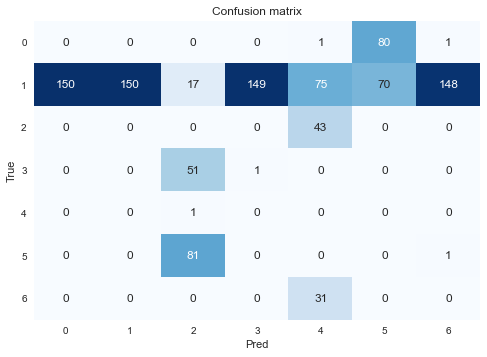

In [362]:

data_word2vec = data_word2vec.fillna(0)
data_text_image = data_word2vec.values 
#clustering_global, labels_global = k_means(data_text_image, X,  7, "Global")
kmeans = KMeans(n_clusters=7, init= 'k-means++', n_init=10)
clustering_global = kmeans.fit_predict(data_text_image)
#adjusted_rand
print(metrics.adjusted_rand_score(df_products_focus['category'], clustering_global))
#confusion_matrix
m_global = confusion_matrix(clustering_global, df_products_focus['category'].values)  
m_global
#classes = np.unique(labels_global)
fig, ax = plt.subplots()
sns.heatmap(m_global, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

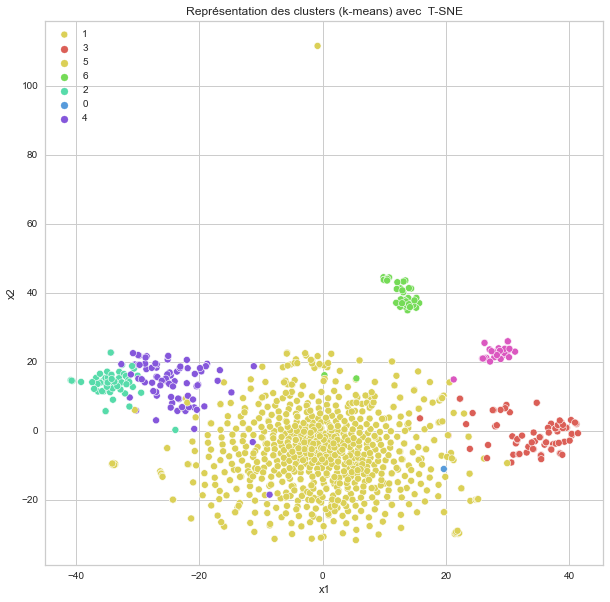

In [368]:
tsne_kmeans(n_clusters, data_word2vec.values, clustering_global, 2) 

In [400]:
data_word2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,0.0,0.0,0.0,0.0,11.387655,0.0,0.0,0.0,0.0,0.0,...,0.000000,56.457672,0.0,0.0,30.503441,23.302755,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,2.554688,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,3.481686,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,9.846517,0.000000,0.0,0.0,39.281593,0.000000,6.781469,0.0,0.000000,0.0


In [406]:
#supervised 
data_word2vec = data_word2vec.fillna(0)
global_data_vector =[]
for e in range (0, len(data_word2vec.values)):
    global_data_vector.append(data_word2vec.values[e].tolist())
print(global_data_vector)

X_train_c, y_train_c, X_test_c,  y_test_c = split_data(global_data_vector, df_products_focus)
#results_cross_validation, bestModelgb =  perform_randomsearch_cross_validation(kFold, 'Gradient Boosting', results_cross_validation)
run_gradient_boosting_prediction(X_train_c, X_test_c, y_train_c, y_test_c)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Accuracy globale : 0.779467680608365
[0.73529412 0.63414634 0.84848485 0.74418605 0.7804878  0.82352941
 0.91891892]


### ajout de couches 

In [390]:
def update_image(image):
    # load an image from file, convert the image pixels to a numpy array, reshape data for the model
    image = load_img(image, target_size=(224, 224))
    #image = transform.resize(image, output_shape=(224, 224))
    array_image = img_to_array(image)
    array_image = np.expand_dims(array_image,  axis=0)
    array_image = preprocess_input(array_image)
    
    return array_image


In [393]:
from PIL import Image

def train_vgg16(images_list_files, image_repository, model):
    vgg16_image_list =[]
    for i in  range (0, len(images_list_files)) : #images_list_files : 
    #for i in  range (0,50) : #images_list_files : 
        image_file = images_list_files[i]
        image_name = image_file[: image_file.index('.')]
        image_file = image_repository +image_file
        if image_file is not None:
            vgg16_image_list.append(update_image(image_file))
    #print(vgg16_image_list)     
    model.fit(np.concatenate(vgg16_image_list, axis=0), df_products_focus['category'], epochs=5, validation_split=0.2, batch_size=3, callbacks=[es])
    
    return vgg16_image_list

In [409]:
from keras.layers import Input, Flatten, Dense
from keras.callbacks import EarlyStopping
vggmodel = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3, ))
vggmodel.trainable = False ## Not trainable weights

flatten_layer = Flatten()
dense_layer_1 = Dense(50, activation='relu')
dense_layer_2 = Dense(20, activation='relu')
prediction_layer = Dense(7, activation='softmax')


model_final = models.Sequential([
    vggmodel,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])


model_final.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
#train_vgg16(images_list_files, image_repository, model_final)
#model_final.fit(data_vgg16.values, df_products_focus['category'], epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])
#get_list_features_vgg16(images_list_files, image_repository_resized, model)

# Annexes

## Classification supervisée multi-classes avec BERT


In [275]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
df = df_products_focus.copy()
df['category'].value_counts()

6    150
5    150
4    150
3    150
2    150
1    150
0    150
Name: category, dtype: int64

In [276]:
possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [277]:
df['label'] = df.category.replace(label_dict)

In [278]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['category', 'label', 'data_type']).count()


uniq_id  product_category_tree  description  \
category label data_type                                                
0        0     train          128                    128          128   
               val             22                     22           22   
1        1     train          128                    128          128   
               val             22                     22           22   
2        2     train          127                    127          127   
               val             23                     23           23   
3        3     train          127                    127          127   
               val             23                     23           23   
4        4     train          127                    127          127   
               val             23                     23           23   
5        5     train          128                    128          128   
               val             22                     22           22   
6        6     train          127                    127          127   
               val             23                     23           23   

                          total_words  cleaned_description  ngram  \
category label data_type                                            
0        0     train              128                  128    128   
               val                 22                   22     22   
1        1     train              128                  128    128   
               val                 22                   22     22   
2        2     train              127                  127    127   
               val                 23                   23     23   
3        3     train              127                  127    127   
               val                 23                   23     23   
4        4     train              127                  127    127   
               val                 23                   23     23   
5        5     train              128                  128    128   
               val                 22                   22     22   
6        6     train              127                  127    127   
               val                 23                   23     23   

                          pos_description  
category label data_type                   
0        0     train                  128  
               val                     22  
1        1     train                  128  
               val                     22  
2        2     train                  127  
               val                     23  
3        3     train                  127  
               val                     23  
4        4     train                  127  
               val                     23  
5        5     train                  128  
               val                     22  
6        6     train                  127  
               val                     23

In [279]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].description.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].description.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

C:\Users\Olfa\anaconda3\lib\site-packages\transformers\configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Olfa\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to

In [280]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [281]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [282]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [283]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [284]:
import random
# Just right before the actual usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 1.3802811574415872
Validation loss: 0.6100739005882785
F1 Score (Weighted): 0.903257044851991



Epoch 2
Training loss: 0.3947017041328769
Validation loss: 0.24900245768422224
F1 Score (Weighted): 0.9233374253878578



Epoch 3
Training loss: 0.18777706971917077
Validation loss: 0.2551500811768731
F1 Score (Weighted): 0.9488591292546843



Epoch 4
Training loss: 0.11943580465385027
Validation loss: 0.22088543033965355
F1 Score (Weighted): 0.9371129924927393



Epoch 5
Training loss: 0.07275279238038765
Validation loss: 0.25075691016742363
F1 Score (Weighted): 0.9429340013257858



In [285]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: 0
Accuracy: 22/22

Class: 1
Accuracy: 15/22

Class: 2
Accuracy: 23/23

Class: 3
Accuracy: 21/23

Class: 4
Accuracy: 19/23

Class: 5
Accuracy: 20/22

Class: 6
Accuracy: 23/23



* Accuracy  par classe : 

* classe 'Home Furnishing' = 1 ,
* classe 'Baby Care' = 0.63,
* classe 'Watches' = 1 ,
* classe 'Home Decor & Festive Needs' = 0.95,
* classe 'Kitchen & Dining' = 0.6, 
* classe 'Beauty and Personal Care' = 0.86,
* classe 'Computers' = 1

* Accuracy globale = 0.86